# Validation

OpenFisca-UK runs unit and integration tests on each new version (see [here](https://github.com/PSLmodels/openfisca-uk/tree/master/tests)).
In addition, the table below shows the aggregates produced by the model for the major taxes and benefits, and comparisons with UKMOD (latest [country report](https://www.iser.essex.ac.uk/research/publications/working-papers/cempa/cempa2-22.pdf)) and official sources.[^1]
UKMOD and administrative sources refer to 2018, and OpenFisca-UK is simulated on policy at the end of 2018.
Numbers are in billions of pounds.

[^1]: From the UKMOD country report: unless otherwise specified: Department for Work and Pensions https://www.gov.uk/government/publications/benefit-expenditure-and-caseload-tables-2018 ; Best Start Grant: https://www2.gov.scot/Topics/Statistics/Browse/Social-Welfare/SocialSecurityforScotland/BSGJune2019; Child tax credit and working tax credit: HMRC statistics 
https://www.gov.uk/government/statistics/child-and-working-tax-credits-statistics-finalised-annual-awards-2016-to-2017; Scottish Child Payment: Scottish Fiscal Commission https://www.fiscalcommission.scot/forecast/supplementary-costing-scottish-child-payment; Scottish Child Winter Heating Assistance: Scottish Fiscal Commission 
https://www.fiscalcommission.scot/forecast/supplementary-costing-child-winter-heating-assistance; Income tax: HMRC statistics https://www.gov.uk/government/statistics/income-tax-liabilities-statistics-tax-year-2014-to-2015-to-tax-year-2017-to-2018; National Insurance Contributions: ONS Blue Book Table 5.2.4s 

## Aggregate tables

OpenFisca-UK uprates input FRS data: below are comparisons between the aggregates calculated by OpenFisca-UK, UKMOD and external sources.

### Aggregates in full

In [16]:
import numpy as np
import pandas as pd
from policyengine_uk import (
    Microsimulation,
    variables as default_variables,
    REPO,
    EnhancedFRS,
    CalibratedFRS,
)
from policyengine_uk.parameter_tree import parameters
from openfisca_core.parameters import ParameterNode
from pathlib import Path
import yaml
import plotly.express as px

policyengine_uk = "OpenFisca-UK"
UKMOD = "UKMOD"
EXTERNAL = "External"

VARIABLES = [
    "child_benefit",
    "income_support",
    "JSA_income",
    "housing_benefit",
    "working_tax_credit",
    "child_tax_credit",
    "universal_credit",
    "pension_credit",
    "income_tax",
    "total_NI",
    "employment_income",
    "self_employment_income",
    "pension_income",
    "property_income",
    "savings_interest_income",
    "dividend_income",
]

sim = Microsimulation(dataset=EnhancedFRS, average_parameters=True)

# https://stackoverflow.com/questions/34667108/ignore-dates-and-times-while-parsing-yaml

yaml.SafeLoader.yaml_implicit_resolvers = {
    k: [r for r in v if r[0] != "tag:yaml.org,2002:timestamp"]
    for k, v in yaml.SafeLoader.yaml_implicit_resolvers.items()
}

with open(
    REPO.parent
    / "docs"
    / "book"
    / "model"
    / "ukmod_country_report_statistics.yaml",
    mode="r",
) as f:
    ukmod_statistics = ParameterNode(
        "ukmod", data=yaml.load(f, Loader=yaml.SafeLoader)
    )


def process_scalar(x, divisor, decimals):
    try:
        if np.isnan(x):
            return x
    except:
        return ""
    return round(x / divisor, decimals)


def model_validation_table(
    model_year_variable_to_result_func,
    title=None,
    start_year=2022,
    end_year=2025,
    divisor=1,
    decimals=0,
    models=[EXTERNAL, policyengine_uk, UKMOD],
    variables=VARIABLES,
):
    dfs = []
    for model in models:
        df = pd.DataFrame(
            {
                year: {
                    default_variables[variable].label: process_scalar(
                        model_year_variable_to_result_func(
                            model, year, variable
                        ),
                        divisor,
                        decimals,
                    )
                    for variable in variables
                }
                for year in range(start_year, end_year + 1)
            }
        )
        dfs.append(df.T)
    return pd.concat(dfs, keys=models).replace(np.nan, "")


def budgetary_impact(model, year, variable):
    try:
        if model == policyengine_uk:
            return sim.calc(variable, map_to="household", period=year).sum()
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(
                f"{year}-01-01"
            )
        elif model == EXTERNAL:
            param = parameters.calibration.programs.children[
                variable
            ].budgetary_impact
            if variable == "income_tax":
                param = param.by_country
            if "UNITED_KINGDOM" in param.children:
                return param.UNITED_KINGDOM(f"{year}-01-01")
            elif "GREAT_BRITAIN" in param.children:
                return param.GREAT_BRITAIN(f"{year}-01-01")
    except Exception as e:
        return np.nan

In [17]:
model_validation_table(budgetary_impact, divisor=1e9, decimals=1)

'ParameterNode' object has no attribute 'income_support'
'ParameterNode' object has no attribute 'JSA_income'
'ParameterNode' object has no attribute 'employment_income'
'ParameterNode' object has no attribute 'self_employment_income'
'ParameterNode' object has no attribute 'pension_income'
'ParameterNode' object has no attribute 'property_income'
'ParameterNode' object has no attribute 'savings_interest_income'
'ParameterNode' object has no attribute 'dividend_income'
'ParameterNode' object has no attribute 'income_support'
'ParameterNode' object has no attribute 'JSA_income'
'ParameterNode' object has no attribute 'employment_income'
'ParameterNode' object has no attribute 'self_employment_income'
'ParameterNode' object has no attribute 'pension_income'
'ParameterNode' object has no attribute 'property_income'
'ParameterNode' object has no attribute 'savings_interest_income'
'ParameterNode' object has no attribute 'dividend_income'
'ParameterNode' object has no attribute 'income_supp

Child Benefit Income Support JSA (income-based)  \
External     2022  11.2           0.7            0.2                 
             2023  11.5           0.5            0.0                 
             2024  11.6           0.5            0.0                 
             2025  11.6           0.4            0.0                 
OpenFisca-UK 2022  11.4           0.7            0.2                 
             2023  11.6           0.5            0.0                 
             2024  11.6           0.5            0.0                 
             2025  11.7           0.3            0.0                 
UKMOD        2022  12.0                                              
             2023  12.3                                              
             2024  12.5                                              
             2025  12.6                                              

                   Housing Benefit  Working Tax Credit  Child Tax Credit  \
External     2022  15.9             3.8                 13.9               
             2023  14.7             3.8                 13.9               
             2024  12.5             3.8                 13.9               
             2025  10.2             3.8                 13.9               
OpenFisca-UK 2022  15.9             1.7                 6.1                
             2023  14.6             1.3                 4.6                
             2024  12.6             0.8                 3.0                
             2025  10.4             0.4                 1.3                
UKMOD        2022  10.3             1.6                 5.4                
             2023  9.6              1.3                 4.5                
             2024  8.5              0.9                 3.3                
             2025  6.7              0.4                 1.5                

                   Universal Credit  Pension Credit  Income Tax  \
External     2022  43.7              4.5             205.0        
             2023  49.8              4.4             215.0        
             2024  57.8              4.4             225.7        
             2025  68.0              4.2             237.5        
OpenFisca-UK 2022  43.2              4.9             199.4        
             2023  48.8              4.8             209.6        
             2024  56.3              4.6             220.3        
             2025  65.0              4.5             226.8        
UKMOD        2022  34.1              4.2             161.2        
             2023  39.1              4.4             170.6        
             2024  39.1              4.5             178.5        
             2025  45.6              4.5             187.9        

                   National Insurance (total) Employment income  \
External     2022  151.3                       814.0              
             2023  157.5                       814.0              
             2024  164.6                       814.0              
             2025  172.1                       814.0              
OpenFisca-UK 2022  150.2                       866.7              
             2023  155.8                       896.2              
             2024  162.7                       925.2              
             2025  170.5                       958.6              
UKMOD        2022  156.0                                          
             2023  145.1                                          
             2024  147.9                                          
             2025  151.9                                          

                  Self-employment income Pension income Rental income  \
External     2022  87.4                                  23.4           
             2023  87.4                                  23.4           
             2024  87.4                                  23.4           
             2025  87.4                                  23.4           
OpenFisca-

### Forecast comparison

'ParameterNode' object has no attribute 'income_support'
'ParameterNode' object has no attribute 'JSA_income'
'ParameterNode' object has no attribute 'employment_income'
'ParameterNode' object has no attribute 'self_employment_income'
'ParameterNode' object has no attribute 'pension_income'
'ParameterNode' object has no attribute 'property_income'
'ParameterNode' object has no attribute 'savings_interest_income'
'ParameterNode' object has no attribute 'dividend_income'
'ParameterNode' object has no attribute 'income_support'
'ParameterNode' object has no attribute 'JSA_income'
'ParameterNode' object has no attribute 'employment_income'
'ParameterNode' object has no attribute 'self_employment_income'
'ParameterNode' object has no attribute 'pension_income'
'ParameterNode' object has no attribute 'property_income'
'ParameterNode' object has no attribute 'savings_interest_income'
'ParameterNode' object has no attribute 'dividend_income'
'ParameterNode' object has no attribute 'income_supp

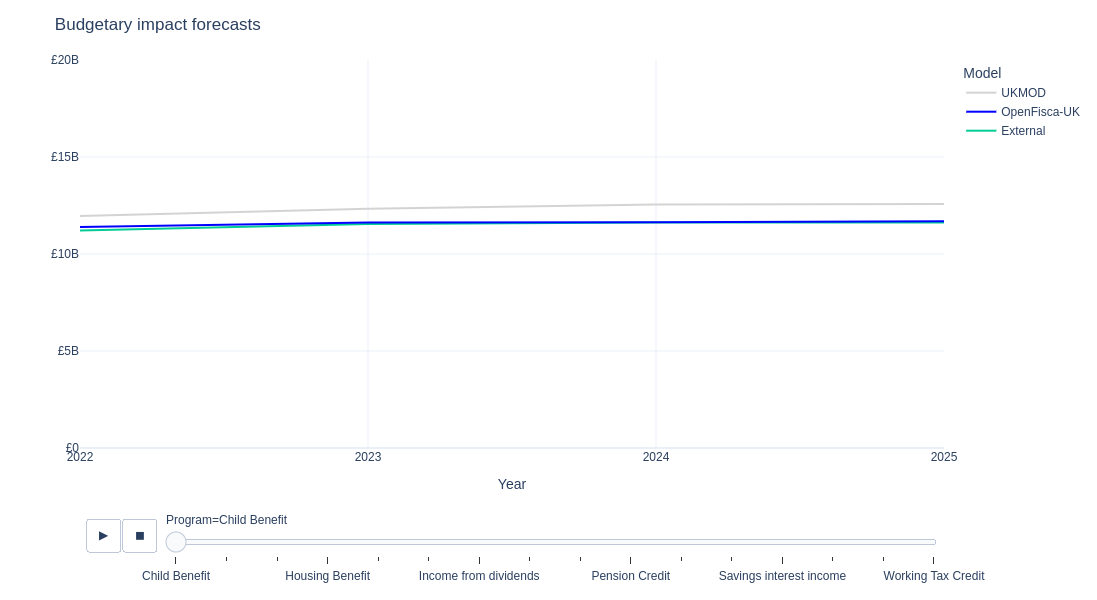

In [18]:
def table_to_model_comparison(table):
    df = table.reset_index()
    df.columns = ["Model", "Year"] + list(table.columns)
    return (
        pd.melt(df, id_vars=["Year", "Model"])
        .pivot(index=["Year", "variable"], columns="Model", values="value")
        .reset_index()
        .rename(columns=dict(variable="Program"))
    )


def tables_to_model_comparisons(tables):
    dfs = []
    for key, table in tables.items():
        df = table_to_model_comparison(table)
        df = df.rename(
            columns={
                column: f"{column} {key}"
                if key != "" and column not in ("Year", "Model", "Program")
                else column
                for column in df.columns
            }
        )
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    return df


def model_forecast_chart(table, title=None, currency=True):
    hovertemplate = ""
    df = table_to_model_comparison(table)
    fig = (
        px.line(
            df,
            animation_frame="Program",
            x="Year",
            y=[EXTERNAL, policyengine_uk, UKMOD],
            color_discrete_map={
                policyengine_uk: "blue",
                UKMOD: "lightgrey",
            },
        )
        .update_layout(
            width=800,
            height=600,
            yaxis_tickprefix="£" if currency else "",
            title=title,
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            yaxis_range=(0, 20e9) if currency else (0, 10e6),
            legend_traceorder="reversed",
            xaxis_tickvals=list(range(2022, 2026)),
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


model_forecast_chart(
    model_validation_table(budgetary_impact, divisor=1, decimals=1),
    title="Budgetary impact forecasts",
)

### Differences

#### Absolute

In [4]:
def budgetary_impact_error(model, year, variable):
    try:
        if model == policyengine_uk:
            return sim.calc(
                variable, map_to="household", period=year
            ).sum() - budgetary_impact(EXTERNAL, year, variable)
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(
                f"{year}-01-01"
            ) - budgetary_impact(EXTERNAL, year, variable)
    except:
        return np.nan


model_validation_table(
    budgetary_impact_error,
    models=[policyengine_uk, UKMOD],
    divisor=1e9,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   
UKMOD        2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   

                  Housing Benefit Working Tax Credit Child Tax Credit  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Universal Credit Pension Credit Income Tax  \
OpenFisca-UK 2022                                              
             2023                                              
             2024                                              
             2025                                              
UKMOD        2022                                              
             2023                                              
             2024                                              
             2025                                              

                  National Insurance (total) Employment income  \
OpenFisca-UK 2022                                                
             2023                                                
             2024                                                
             2025                                                
UKMOD        2022                                                
             2023                                                
             2024                                                
             2025                                                

                  Self-employment income Pension income Rental income  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Savings interest income Income from dividends  
OpenFisca-UK 2022                                                
             2023                                                
             2024                                                
             2025                                                
UKMOD        2022                                                
             2023                                                
             2024                                                
             2025

#### Relative

In [5]:
def relative_budgetary_impact_error(model, year, variable):
    try:
        if model == policyengine_uk:
            return (
                sim.calc(variable, map_to="household", period=year).sum()
                / budgetary_impact(EXTERNAL, year, variable)
                - 1
            )
        elif model == UKMOD:
            return (
                getattr(ukmod_statistics.ukmod.budgetary_impact, variable)(
                    f"{year}-01-01"
                )
                / budgetary_impact(EXTERNAL, year, variable)
                - 1
            )
    except:
        return np.nan


model_validation_table(
    relative_budgetary_impact_error,
    models=[policyengine_uk, UKMOD],
    divisor=1e-2,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   
UKMOD        2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   

                  Housing Benefit Working Tax Credit Child Tax Credit  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Universal Credit Pension Credit Income Tax  \
OpenFisca-UK 2022                                              
             2023                                              
             2024                                              
             2025                                              
UKMOD        2022                                              
             2023                                              
             2024                                              
             2025                                              

                  National Insurance (total) Employment income  \
OpenFisca-UK 2022                                                
             2023                                                
             2024                                                
             2025                                                
UKMOD        2022                                                
             2023                                                
             2024                                                
             2025                                                

                  Self-employment income Pension income Rental income  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Savings interest income Income from dividends  
OpenFisca-UK 2022                                                
             2023                                                
             2024                                                
             2025                                                
UKMOD        2022                                                
             2023                                                
             2024                                                
             2025

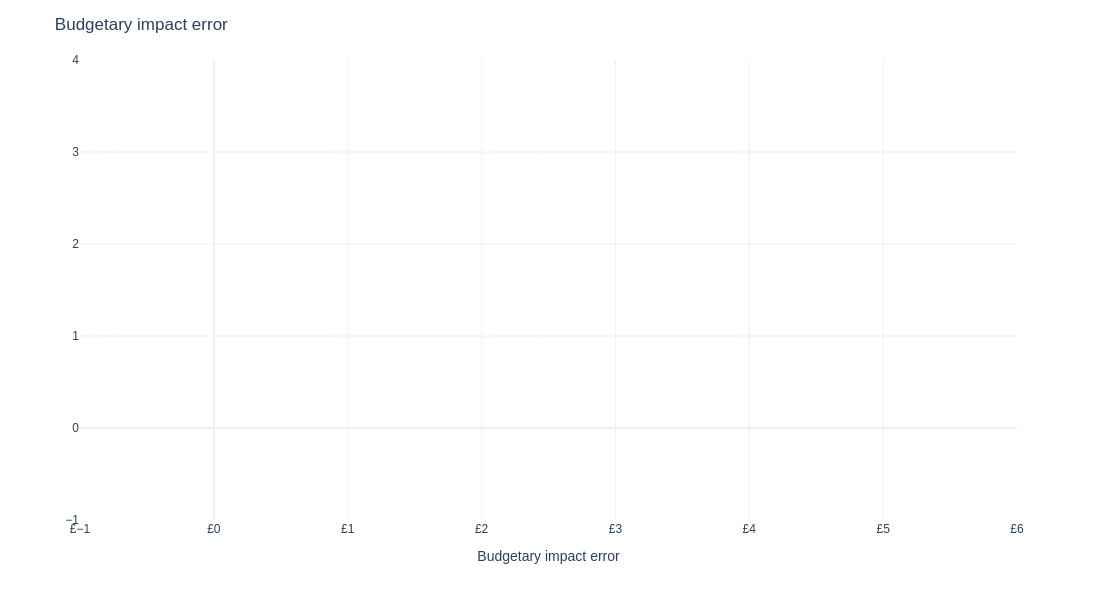

In [6]:
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)


def error_chart(table, title=None):
    hovertemplate = "<b>%{customdata[4]} in %{customdata[3]}</b><br>Error: %{x}<br>Official: £%{customdata[2]}bn<br>OpenFisca-UK: £%{customdata[0]}bn<br>UKMOD: £%{customdata[1]}bn"
    table = table.replace("", np.nan).dropna(axis=0)
    table[[policyengine_uk, UKMOD]] = table[[policyengine_uk, UKMOD]].abs() / 1e2
    fig = (
        px.bar(
            table.sort_values(["Year", policyengine_uk]),
            x=[policyengine_uk, UKMOD],
            y="Program",
            orientation="h",
            animation_frame="Year",
            barmode="group",
            color_discrete_map={
                policyengine_uk: "blue",
                UKMOD: "lightgrey",
            },
            custom_data=[
                "OpenFisca-UK budgetary impact",
                "UKMOD budgetary impact",
                "External budgetary impact",
                "Year",
                "Program",
            ],
        )
        .update_layout(
            width=800,
            height=600,
            xaxis_tickprefix="£",
            xaxis_title="Budgetary impact error",
            title=title,
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            legend_traceorder="reversed",
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


error_chart(
    tables_to_model_comparisons(
        {
            "": model_validation_table(
                budgetary_impact_error,
                models=[policyengine_uk, UKMOD],
                divisor=1e-2,
                decimals=1,
            ),
            "budgetary impact": model_validation_table(
                budgetary_impact, divisor=1e9, decimals=1
            ),
        }
    ),
    title="Budgetary impact error",
)

## Caseload tables

OpenFisca-UK uprates input FRS data: below are comparisons between the aggregates calculated by OpenFisca-UK, UKMOD and external sources.

### Caseloads in full

In [7]:
from microdf import MicroSeries
from openfisca_core.parameters import Parameter


def get_nonzero(variable, year):
    entity = default_variables[variable].entity.key
    values = sim.calc(variable, period=year) > 0
    return MicroSeries(
        sim.map_to(values, entity, "household"),
        weights=sim.calc("household_weight", year),
    )


def caseload(model, year, variable):
    try:
        if model == policyengine_uk:
            return get_nonzero(variable, year).sum()
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(
                f"{year}-01-01"
            )
        elif model == EXTERNAL:
            if variable == "income_tax":
                total = 0
                for (
                    subparam
                ) in (
                    parameters.calibration.programs.income_tax.participants.by_country_and_band.get_descendants()
                ):
                    if isinstance(subparam, Parameter):
                        total += subparam(f"{year}-01-01")
                return total
            try:
                return parameters.calibration.programs.children[
                    variable
                ].participants.UNITED_KINGDOM(f"{year}-01-01")
            except:
                return parameters.calibration.programs.children[
                    variable
                ].participants.GREAT_BRITAIN(f"{year}-01-01")
    except:
        return np.nan


model_validation_table(
    caseload, models=[EXTERNAL, policyengine_uk, UKMOD], divisor=1e6, decimals=2
)

Child Benefit Income Support JSA (income-based)  \
External     2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   
OpenFisca-UK 2022  7.16          0.17           0.05                
             2023  7.03          0.13           0.01                
             2024  6.93          0.08           0.0                 
             2025  6.89          0.04           0.0                 
UKMOD        2022  7.12                                             
             2023  7.07                                             
             2024  7.02                                             
             2025  6.99                                             

                  Housing Benefit Working Tax Credit Child Tax Credit  \
External     2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
OpenFisca-UK 2022  2.78            0.78               1.25              
             2023  2.52            0.57               0.91              
             2024  2.15            0.36               0.56              
             2025  1.76            0.16               0.24              
UKMOD        2022  2.26            0.54               1.08              
             2023  2.05            0.44               0.89              
             2024  1.78            0.3                0.64              
             2025  1.43            0.13               0.29              

                  Universal Credit Pension Credit Income Tax  \
External     2022                                              
             2023                                              
             2024                                              
             2025                                              
OpenFisca-UK 2022  4.95             1.62           31.17       
             2023  5.58             1.52           32.37       
             2024  6.16             1.4            33.51       
             2025  7.02             1.31           34.75       
UKMOD        2022  4.21             1.41           30.01       
             2023  4.66             1.45           30.58       
             2024  5.31             1.44           30.94       
             2025  6.15             1.42           31.47       

                  National Insurance (total) Employment income  \
External     2022                                                
             2023                                                
             2024                                                
             2025                                                
OpenFisca-UK 2022  26.36                      32.32              
             2023  26.62                      32.16              
             2024  27.13                      32.12              
             2025  27.77                      32.19              
UKMOD        2022  26.08                                         
             2023  26.19                                         
             2024  26.24                                         
             2025  26.27                                         

                  Self-employment income Pension income Rental income  \
External     2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
OpenFisca-UK 2022  4.63                   11.4           2.6            
             2023  4.62                 

### Caseload forecasts

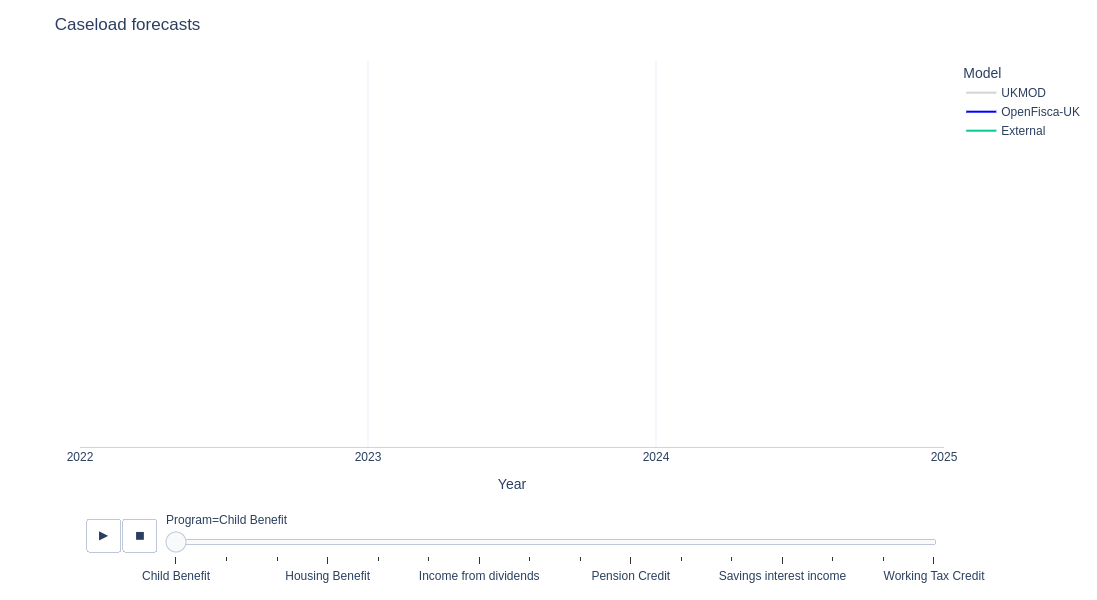

In [8]:
model_forecast_chart(
    model_validation_table(
        caseload, models=[EXTERNAL, policyengine_uk, UKMOD], divisor=1, decimals=1
    ),
    title="Caseload forecasts",
    currency=False,
)

### Differences

#### Absolute

In [9]:
def caseload_error(model, year, variable):
    try:
        if model == policyengine_uk:
            return get_nonzero(variable, year).sum() - caseload(
                EXTERNAL, year, variable
            )
        elif model == UKMOD:
            return getattr(ukmod_statistics.ukmod.nonzero_units, variable)(
                f"{year}-01-01"
            ) - caseload(EXTERNAL, year, variable)
    except:
        return np.nan


model_validation_table(
    caseload_error,
    variables=VARIABLES[:-1],
    models=[policyengine_uk, UKMOD],
    divisor=1e6,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   
UKMOD        2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   

                  Housing Benefit Working Tax Credit Child Tax Credit  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Universal Credit Pension Credit Income Tax  \
OpenFisca-UK 2022                                              
             2023                                              
             2024                                              
             2025                                              
UKMOD        2022                                              
             2023                                              
             2024                                              
             2025                                              

                  National Insurance (total) Employment income  \
OpenFisca-UK 2022                                                
             2023                                                
             2024                                                
             2025                                                
UKMOD        2022                                                
             2023                                                
             2024                                                
             2025                                                

                  Self-employment income Pension income Rental income  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Savings interest income  
OpenFisca-UK 2022                          
             2023                          
             2024                          
             2025                          
UKMOD        2022                          
             2023                          
             2024                          
             2025

#### Relative

In [10]:
def relative_caseload_error(model, year, variable):
    try:
        if model == policyengine_uk:
            return (
                get_nonzero(variable, year).sum()
                / caseload(EXTERNAL, year, variable)
                - 1
            )
        elif model == UKMOD:
            return (
                getattr(ukmod_statistics.ukmod.nonzero_units, variable)(
                    f"{year}-01-01"
                )
                / caseload(EXTERNAL, year, variable)
                - 1
            )
    except:
        return np.nan


model_validation_table(
    relative_caseload_error,
    variables=VARIABLES[:-1],
    models=[policyengine_uk, UKMOD],
    divisor=1e-2,
    decimals=1,
)

Child Benefit Income Support JSA (income-based)  \
OpenFisca-UK 2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   
UKMOD        2022                                                   
             2023                                                   
             2024                                                   
             2025                                                   

                  Housing Benefit Working Tax Credit Child Tax Credit  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Universal Credit Pension Credit Income Tax  \
OpenFisca-UK 2022                                              
             2023                                              
             2024                                              
             2025                                              
UKMOD        2022                                              
             2023                                              
             2024                                              
             2025                                              

                  National Insurance (total) Employment income  \
OpenFisca-UK 2022                                                
             2023                                                
             2024                                                
             2025                                                
UKMOD        2022                                                
             2023                                                
             2024                                                
             2025                                                

                  Self-employment income Pension income Rental income  \
OpenFisca-UK 2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       
UKMOD        2022                                                       
             2023                                                       
             2024                                                       
             2025                                                       

                  Savings interest income  
OpenFisca-UK 2022                          
             2023                          
             2024                          
             2025                          
UKMOD        2022                          
             2023                          
             2024                          
             2025

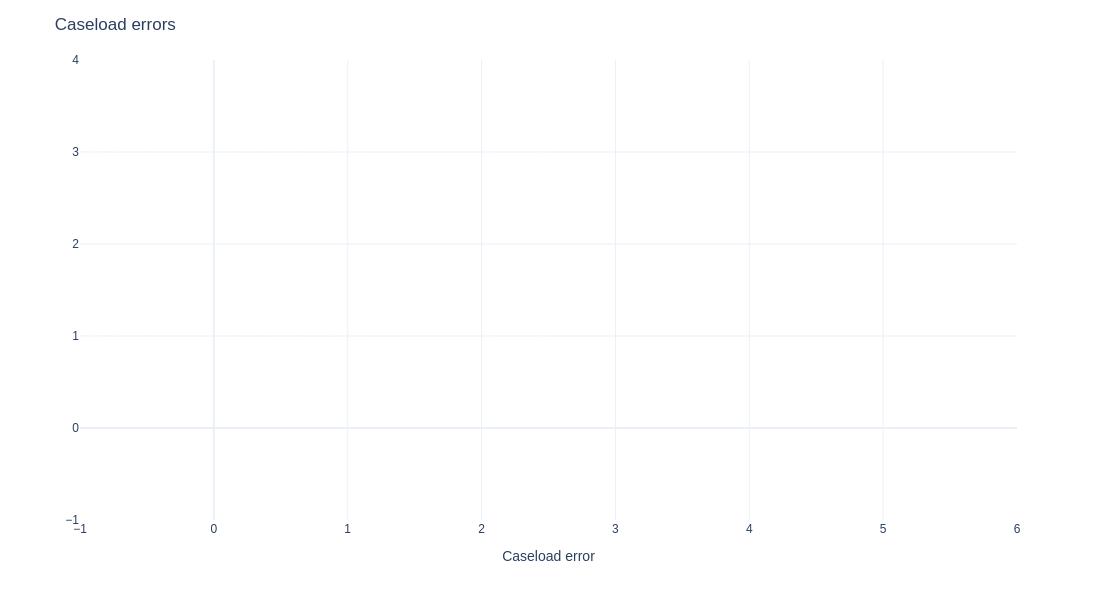

In [11]:
def error_chart(table, title=None):
    hovertemplate = "<b>%{customdata[4]} in %{customdata[3]}</b><br>Error: %{x}<br>Official: %{customdata[2]}m<br>OpenFisca-UK: %{customdata[0]}m<br>UKMOD: %{customdata[1]}m"
    table = table.replace("", np.nan).dropna(axis=0)
    table[[policyengine_uk, UKMOD]] = table[[policyengine_uk, UKMOD]].abs() / 1e2
    fig = (
        px.bar(
            table.sort_values(["Year", policyengine_uk]),
            x=[policyengine_uk, UKMOD],
            y="Program",
            orientation="h",
            animation_frame="Year",
            barmode="group",
            color_discrete_map={
                policyengine_uk: "blue",
                UKMOD: "lightgrey",
            },
            custom_data=[
                "OpenFisca-UK caseload",
                "UKMOD caseload",
                "External caseload",
                "Year",
                "Program",
            ],
        )
        .update_layout(
            width=800,
            height=600,
            xaxis_title="Caseload error",
            title=title,
            template="plotly_white",
            legend_title="Model",
            yaxis_title="",
            legend_traceorder="reversed",
        )
        .update_traces(hovertemplate=hovertemplate)
    )
    for frame in fig.frames:
        for data in frame.data:
            data.hovertemplate = hovertemplate
    return fig


error_chart(
    tables_to_model_comparisons(
        {
            "": model_validation_table(
                caseload_error,
                models=[policyengine_uk, UKMOD],
                decimals=1,
                divisor=1e-2,
            ),
            "caseload": model_validation_table(
                caseload, divisor=1e6, decimals=1
            ),
        }
    ),
    title="Caseload errors",
)

## Automated tests

Below are test results from the most recent version.

In [12]:
from policyengine_uk.tests.microsimulation.test_statistics import tests

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.DataFrame({"Name": tests, "Passed": [test.test()[0] for test in tests]})

,Name,Passed
0,OpenFisca-UK Child Benefit caseload error is less than 10.0% in 2022,True
1,OpenFisca-UK Council Tax (less CTB) aggregate error is less than 11.0% in 2022,True
2,OpenFisca-UK Child Tax Credit aggregate error is less than 40.0% in 2022,True
3,OpenFisca-UK Child Tax Credit caseload error is less than 25.0% in 2022,True
4,OpenFisca-UK Working Tax Credit caseload error is less than 40.0% in 2022,True
5,OpenFisca-UK Housing Benefit caseload error is less than 15.0% in 2022,True
6,OpenFisca-UK JSA (income-based) aggregate error is less than 110.0% in 2022,True
7,OpenFisca-UK Income Support caseload error is less than 15.0% in 2022,True
8,OpenFisca-UK Universal Credit caseload error is less than 20.0% in 2022,True
9,OpenFisca-UK Income Tax caseload error is less than 12.5% in 2022,True
